In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
import gym
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import random


In [4]:
import gym_super_mario_bros

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
print(env.observation_space.shape)  # Dimensions of a frame
print(env.action_space.n)  # Number of actions our agent can take

(240, 256, 3)
256


In [6]:
from gym import spaces
from torchvision import transforms as T

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info
    
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = spaces.Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        self.transform = T.Grayscale()

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        observation = self.transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = spaces.Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)
        self.transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )

    def observation(self, observation):
        observation = self.transforms(observation).squeeze(0)
        return observation


In [7]:
import gym
import gym_super_mario_bros
from gym.wrappers import RecordVideo, FrameStack
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY

import time

video_dir_path = 'mario_videos'

def make_env(env, video_dir_path=None):
    """Apply a series of wrappers to the environment."""
    env = JoypadSpace(env, RIGHT_ONLY)  # Reduce action space
    
    if video_dir_path is not None:
        env = RecordVideo(
            env,
            video_folder=video_dir_path,
            episode_trigger=lambda episode_id: True,
            name_prefix='mario-video-{}'.format(time.ctime())
        )
    
    #env = RecordEpisodeStatistics(env)  # Track stats
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env)  # Convert to grayscale
    env = ResizeObservation(env, 84)  # Resize to 84x84
    env = FrameStack(env, num_stack=4)  # Stack 4 frames
    return env

## Testing cell

In [8]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = make_env(env)

c = 0
images = None
# run 1 episode
env.reset()
while True:
    action = env.action_space.sample()
    action = 0
    state, reward, done, _, info = env.step(action)
    if c==50:
        images = state
    #time.sleep(1/30)
    if done or info['time'] < 380:
        break
    c+=1
env.close()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axes[i].imshow(images[i], cmap='gray')
plt.show()

ImportError: Library "GLU" not found.

In [8]:
class DQNSolver(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        #input_shape = (4, 84, 84)
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(*shape))
        return int(np.prod(o.size()))

    def forward(self, x: torch.Tensor):
        x = x.squeeze(-1)
        conv_out = self.conv(x).reshape(x.size()[0], -1)
        return self.fc(conv_out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=(3, 3), 
            padding='same', 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=(3, 3), 
                    padding='same', 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x) if self.downsample else x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x + identity)

        return x

class DQNSolverResNet(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQNSolverResNet, self).__init__()
        #input_shape = (4, 84, 84)  # Fix input shape for processing stacked frames

        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU()
        )

        self.res_block1 = ResidualBlock(32, 64)
        self.res_block2 = ResidualBlock(64, 64)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        """Calculate output size after conv layers."""
        o = self.forward_conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward_conv(self, x):
        """Apply convolutional and residual layers."""
        x = self.initial_conv(x)
        x = self.maxpool(self.res_block1(x))
        x = self.maxpool(self.res_block2(x))
        return x

    def forward(self, x: torch.Tensor):
        """Compute forward pass."""
        x = x.squeeze(-1)
        conv_out = self.forward_conv(x).reshape(x.size()[0], -1)
        return self.fc(conv_out)



In [9]:
block = ResidualBlock(in_channels=64, out_channels=64)
x = torch.randn(4, 64, 32, 32)  # Batch size 4, 64 channels, 32x32 spatial size
out = block(x)
assert(out.shape == x.shape, "Output shape should match input shape when stride=1")

block = ResidualBlock(in_channels=32, out_channels=64)
x = torch.randn(4, 32, 32, 32)
out = block(x)
assert(out.shape == (4, 64, 32, 32), "Output shape mismatch when increasing channels")

block = ResidualBlock(in_channels=64, out_channels=64)
x = torch.randn(4, 64, 32, 32)
out = block(x)
assert torch.all(out != x)

model = DQNSolver(input_shape=(4, 84, 84), n_actions=6)
x = torch.randn(4, 4, 84, 84)  # Batch size 4
out = model(x)
assert out.shape == (4, 6), "DQNSolver output shape mismatch"

model = DQNSolverResNet(input_shape=(4, 84, 84), n_actions=6)
x = torch.randn(4, 4, 84, 84)  # Batch size 4
out = model(x)
assert out.shape == (4, 6), "DQNSolverResNet output shape mismatch"

model = DQNSolverResNet(input_shape=(4, 84, 84), n_actions=6)
x = torch.randn(4, 4, 84, 84)
features = model.forward_conv(x)
assert len(features.shape) == 4, "Feature map should have 4 dimensions (batch, channels, H, W)"

In [10]:
class DQNAgent:
    def __init__(self, state_space, action_space, max_memory_size: int = 30000, batch_size: int = 64, gamma: float = 0.9, lr: float = 0.00025, exploration_max: float = 0.90, exploration_min: float = 0.02, exploration_decay: float = 0.999, model=DQNSolver):    

        self.state_space = state_space
        self.action_space = action_space
        self.max_memory_size = max_memory_size
        self.memory_sample_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.exploration_max = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.exploration_rate = self.exploration_max
        self.step = 0
        self.copy = 2500  # Copy target model weights every n steps
        
        # Memory Buffers
        self.STATE_MEM = torch.zeros((max_memory_size, *state_space))
        self.ACTION_MEM = torch.zeros((max_memory_size, 1))
        self.REWARD_MEM = torch.zeros((max_memory_size, 1))
        self.STATE2_MEM = torch.zeros((max_memory_size, *state_space))
        self.DONE_MEM = torch.zeros((max_memory_size, 1))
        self.ending_position = 0
        self.num_in_queue = 0

        # Neural Networks
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.local_net = model(state_space, action_space).to(self.device)
        self.target_net = model(state_space, action_space).to(self.device)
        self.target_net.load_state_dict(self.local_net.state_dict())
        self.target_net.eval()

        self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.99)
        self.l1 = nn.SmoothL1Loss()

    def save(self, path):
        torch.save(self.local_net.state_dict(), path)

    def load(self, path):
        self.local_net.load_state_dict(torch.load(path))
        self.local_net.to(self.device)

    def act(self, state, evaluate=False, sample=False):
        """Select an action using an epsilon-greedy policy"""
        
        if random.random() < self.exploration_rate and not evaluate:
            return torch.tensor([[random.randrange(self.action_space)]], dtype=torch.long, device=self.device)
        else:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device).unsqueeze(0)
                out = self.local_net(state.to(self.device))
                if sample:
                    out = torch.softmax(out, dim=-1)
                    return torch.tensor([[random.choices(range(self.action_space), weights=out.squeeze().tolist())[0]]], dtype=torch.long, device=self.device)
                else:
                    return out.argmax(dim=1, keepdim=True).cpu().float()

    def copy_model(self):
        """Copy local network weights to target network"""
        self.target_net.load_state_dict(self.local_net.state_dict())

    def update_exploration_rate(self):
        """Decay exploration rate"""
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)


    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float().clone().detach()
        self.ACTION_MEM[self.ending_position] = action.float().clone().detach()
        self.REWARD_MEM[self.ending_position] = reward.float().clone().detach()
        self.STATE2_MEM[self.ending_position] = state2.float().clone().detach()
        self.DONE_MEM[self.ending_position] = done.float().clone().detach()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO buffer
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)

        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.sample(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx].to(self.device)
        ACTION = self.ACTION_MEM[idx].to(self.device)
        REWARD = self.REWARD_MEM[idx].to(self.device)
        STATE2 = self.STATE2_MEM[idx].to(self.device)
        DONE = self.DONE_MEM[idx].to(self.device)
        
        return STATE, ACTION, REWARD, STATE2, DONE
        
    def experience_replay(self, num_replay: int = 1):
        
        for _ in range(num_replay):
            if self.step % self.copy == 0:
                self.copy_model()

            # Wait until enough samples are in queue
            if self.memory_sample_size > self.num_in_queue:
                return

            STATE, ACTION, REWARD, STATE2, DONE = self.recall()
            
            self.optimizer.zero_grad()
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long())
            loss = self.l1(current, target.detach())
            loss.backward()
            self.optimizer.step()
            self.step += 1

In [11]:
def evaluate_agent(agent: DQNAgent, env: gym.Env, num_episodes=1, show: bool = False) -> float:
    """Runs the trained agent in the environment without training."""
    
    total_rewards = []
    
    for ep_num in range(num_episodes):
        state, info = env.reset()
        state = torch.Tensor(state[0].__array__() if isinstance(state, tuple) else state.__array__())
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state, evaluate=True)  # Use deterministic policy
            state_next, reward, done, _, info = env.step(int(action.item()))
            if show:
                time.sleep(1/30)
            done = done or info['time'] < 250
            
            total_reward += reward
            state = torch.Tensor(state_next[0].__array__() if isinstance(state_next, tuple) else state_next.__array__())
        
        total_rewards.append(total_reward)
        if show:
            print(f"Evaluation Episode {ep_num + 1}: Total Reward = {total_reward}")
    if show:
        print(f"Average Reward over {num_episodes} episodes: {np.mean(total_rewards)}")
    return np.mean(total_rewards)

def eval_all(agent: DQNAgent, levels = None, verbose: bool = True) -> float:
    rewards = []

    if levels is None:
        worlds = list(range(1, 9))
        stages = list(range(1, 5))
        levels = []
        for world in worlds:
            for stage in stages:
                levels.append(f"{world}-{stage}")


    for level in levels:
        env = gym_super_mario_bros.make(f'SuperMarioBros-{level}-v0', apply_api_compatibility=True, render_mode='rgb_array')
        env = make_env(env)
        rewards.append(evaluate_agent(agent, env))
        env.close()
        if verbose:
            print("Stage {}: Reward = {}".format(level, rewards[-1]))

    return np.mean(rewards)

In [ ]:
import matplotlib.pyplot as plt

def train(agent: DQNAgent, env: gym.Env, num_episodes: int = 10, eval_step: int = 10, levels = None) -> DQNAgent:    
    total_rewards = [0]
    eval_rewards = [0]
    eval_ep = []
    
    for ep_num in (pbar := tqdm(range(num_episodes))):
        state, info = env.reset()

        # State is a LazyFrame
        state = torch.Tensor(state[0].__array__() if isinstance(state, tuple) else state.__array__())

        total_reward = 0
        while True:
            pbar.set_postfix_str(f"Step {agent.step}, Train Reward {total_rewards[-1]}, Eval Reward {eval_rewards[-1]}")

            action = agent.act(state, sample=True)
            
            state_next, reward, terminal, trunc, info = env.step(int(action.item()))
            total_reward += reward
            
            state_next = torch.Tensor(state_next[0].__array__() if isinstance(state_next, tuple) else state_next.__array__())
            reward = torch.tensor([reward])#.unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)])#.unsqueeze(0)
            agent.remember(state, action, reward, state_next, terminal)
            agent.experience_replay(num_replay=10)
            
            state = state_next
            if terminal:
                break

        agent.scheduler.step()
        
        total_rewards.append(total_reward)
        agent.save('mario_model.pth')

        if ep_num % eval_step == 0:
            eval_rewards.append(eval_all(agent, levels=levels, verbose=False))
            eval_ep.append(ep_num)

    return agent, eval_ep, eval_rewards[1:], total_rewards

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', apply_api_compatibility=True, render_mode='rgb_array')
env = make_env(env)#, 'training_videos')
observation_space = env.observation_space.shape
action_space = env.action_space.n
agent = DQNAgent(state_space=observation_space, action_space=action_space, lr=1e-4, batch_size=128, exploration_decay=0.99 , model=DQNSolverResNet)
env.close()

In [ ]:
import os
if os.path.exists('mario_model.pth'):
    agent.load('mario_model.pth')

levels = ['1-1']#, '1-2', '1-3', '1-4']
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', stages=levels, apply_api_compatibility=True, render_mode='rgb_array')
#env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode='rgb_array')
env = make_env(env)#, 'training_videos')

print(f"Start training on {agent.device}")
agent, eval_ep, eval_rewards, total_rewards = train(agent, env, num_episodes=50, levels=levels)
env.close()
agent.save('mario_model.pth')

Start training on cuda


  4%|▍         | 40/1000 [43:18<17:19:25, 64.96s/it, Step 104890, Reward 760.0] 


KeyboardInterrupt: 

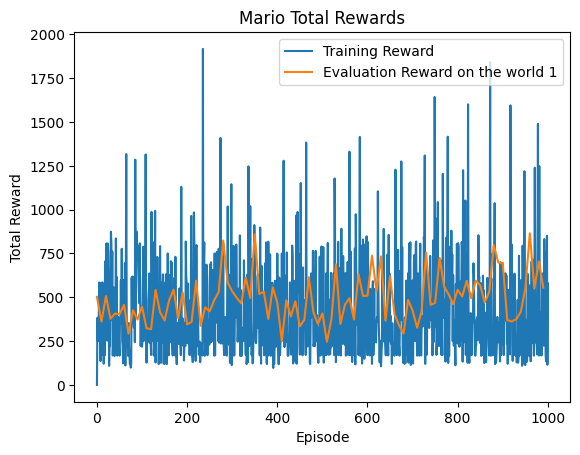

In [ ]:
plt.plot(total_rewards, label="Training Reward")
plt.plot(eval_ep, eval_rewards, label="Evaluation Reward on the world 1")
plt.title("Mario Total Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

In [15]:
import os
if os.path.exists('mario_model.pth'):
    agent.load('mario_model.pth')

mean_reward = eval_all(agent)
print(f"Average Reward over all stages: {np.mean(mean_reward)}")


/home/maxence/miniconda3/envs/rl_project/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Stage 1-1: Reward = 611.0
Stage 1-2: Reward = 131.0
Stage 1-3: Reward = 353.0


KeyboardInterrupt: 

In [16]:
env = gym_super_mario_bros.make(f'SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode='human')
env = make_env(env)
evaluate_agent(agent, env, show=True)
env.close()

Evaluation Episode 1: Total Reward = 611.0
Average Reward over 1 episodes: 611.0


In [ ]:
#from record import record_mario_gameplay
# This will play and record Mario with random actions\n"
#gif_path = record_mario_gameplay()
#print(f"GIF saved to: {gif_path}")